In [62]:
# !pip3 install git+ssh://git@github.com/Holmusk/neuroblu_postgres.git@v1.0.2#egg=neuroblu_postgres
# !pip3 install psycopg2-binary
# !pip3 install statsmodels
# !pip3 install git+https://github.com/lsmoriginal/Tacos.git#egg=Tacos

  Cloning https://github.com/lsmoriginal/Tacos.git to /tmp/pip-install-40lozv89/tacos_f463b672d3974f5ab585e16ec38cdcc1
  Running command git clone --filter=blob:none --quiet https://github.com/lsmoriginal/Tacos.git /tmp/pip-install-40lozv89/tacos_f463b672d3974f5ab585e16ec38cdcc1
  Resolved https://github.com/lsmoriginal/Tacos.git to commit 54d5023cca95f224e7f5e53070754cea96105a26
  Preparing metadata (setup.py) ... done
  Using cached Pillow-8.3.1-cp310-cp310-linux_x86_64.whl
Using legacy 'setup.py install' for Tacos, since package 'wheel' is not installed.
  Attempting uninstall: Pillow
    Found existing installation: Pillow 9.2.0
    Uninstalling Pillow-9.2.0:
      Successfully uninstalled Pillow-9.2.0
  Running setup.py install for Tacos ... done

[notice] A new release of pip available: 22.1.2 -> 22.2.1
[notice] To update, run: pip install --upgrade pip


In [20]:
import pandas as pd
import seaborn as sns

from itertools import chain
from pathlib import Path
import re

import os
os.environ["DB_PATH"]='../../db.json'
from neuroblu_postgres.databaseIO import pgIO

# Distribution of the current tokens

In [6]:
# about 1min for 11Million rows
tokenCountFrSourceDbDfPath = Path('tokenCountFrSourceDbDf.csv')

if not tokenCountFrSourceDbDfPath.exists():
    tokenCountFrSourceDb = pgIO.getDataIterator(
        query=f'''
        SELECT 
            sentences.database, 
            sentences.sentence, 
            sentences.n_token
        FROM v1_nlp.sentences
        ; 
        ''',
        dbName='NLP_CDM',
        chunks=10000,
    )
    alldata = chain(*tokenCountFrSourceDb)

    tokenCountFrSourceDbDf = pd.DataFrame(
        alldata,
        columns=['database','sentence', 'n_token'],
    )
    tokenCountFrSourceDbDf.to_csv(
        tokenCountFrSourceDbDfPath,
        index=False
    )
else:
    tokenCountFrSourceDbDf = pd.read_csv(
        tokenCountFrSourceDbDfPath,
    )

In [7]:
tokenCountFrSourceDbDf.shape
# 11 Million sentences

(11535536, 3)

<AxesSubplot:xlabel='n_token', ylabel='Count'>

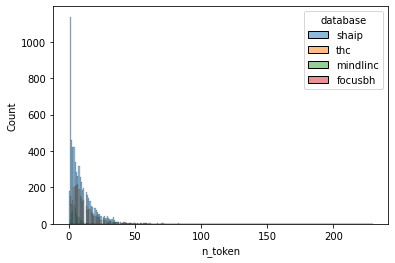

In [32]:
sns.histplot(
    data=tokenCountFrSourceDbDf.sample(10000),
    x='n_token',
    hue='database',
)

<AxesSubplot:xlabel='database', ylabel='n_token'>

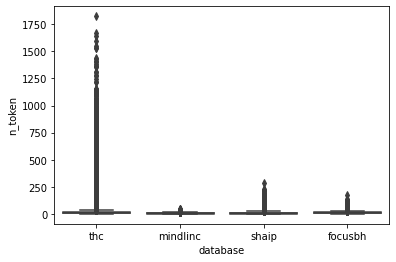

In [33]:
sns.boxplot(
    data=tokenCountFrSourceDbDf,
    y='n_token',
    x='database'
)

Harris center is the worst in terms of sentence tokenizing.

In [39]:
shaipLongSent = tokenCountFrSourceDbDf[(tokenCountFrSourceDbDf.database=='shaip') & (tokenCountFrSourceDbDf.n_token >=150)]
shaipLongSent.head()

,database,sentence,n_token
3825824,shaip,"upon challenging her, it takes a significant a...",211
3897103,shaip,"since he had already paid his money, he to thi...",197
3967719,shaip,the patient was last discharged range of motio...,158
3967763,shaip,he has to maintain a gpa of 3.2 to stay in his...,153
4852292,shaip,i am going to continue the same medications at...,164


# Why does thc has such ridiculously long sentences

* \\n next line chars 
* \r\n repetitions -> most probably point forms
* ____________ underscores  

In [9]:
sampleLongText=tokenCountFrSourceDbDf[(tokenCountFrSourceDbDf.database=='thc') & (tokenCountFrSourceDbDf.n_token >=1750)].sentence[2274188]
sampleLongText[:2500]

'INPERSON VISIT NOT AVAILBLE FOR REASON OF Covid 19, today\'s routine follow up appointment was conducted via telephone\r\nthe client consented to a telephone appointment\r\nhe reports taking his medication daily as prescribed\r\nall medication is working well\r\nhis mood is stable\r\nhe denies mood swings and depression\r\nhe denies AVH, delusions and paranoia\r\nappetite and sleep pattern are intact\r\nenergy level and motivation are good\r\nthe current medication regimen is effective and there are no side effects\r\nhe denies SI/HI or any thought of harm to self or others\r\n\r\nhe has a transfer appointment scheduled for [DATE_5]\r\nhe has requested to begin therapy and counseling \r\nhe will begin therapy once transferred out of New START, as New START does not provide therapy\r\nhe is aware of this plan and agrees\r\n\r\n______________________________________________________________________________________\r\nINPERSON VISIT NOT AVAILBLE FOR REASON OF Covid 19, today\'s routine fo

In [29]:
# !pip3 install spacy==3.2.4
# !pip3 install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.0/en_core_sci_scibert-0.5.0.tar.gz
# !python -m spacy download en_core_web_trf
# !python -m spacy download en_core_web_sm

In [11]:

import spacy
nlp=spacy.load("en_core_sci_scibert")
doc = nlp("input text")
cleaned_data=list(item.text for item in doc.sents)

User provided device_type of 'cuda', but CUDA is not available. Disabling


In [14]:
# breaking a long sentences takes 11secs
doc = nlp(sampleLongText)
cleaned_data_en_core_sci_scibert=list(item.text for item in doc.sents)

User provided device_type of 'cuda', but CUDA is not available. Disabling


In [25]:
re.sub("_{3,}", ' \n ', sampleLongText)

'INPERSON VISIT NOT AVAILBLE FOR REASON OF Covid 19, today\'s routine follow up appointment was conducted via telephone\r\nthe client consented to a telephone appointment\r\nhe reports taking his medication daily as prescribed\r\nall medication is working well\r\nhis mood is stable\r\nhe denies mood swings and depression\r\nhe denies AVH, delusions and paranoia\r\nappetite and sleep pattern are intact\r\nenergy level and motivation are good\r\nthe current medication regimen is effective and there are no side effects\r\nhe denies SI/HI or any thought of harm to self or others\r\n\r\nhe has a transfer appointment scheduled for [DATE_5]\r\nhe has requested to begin therapy and counseling \r\nhe will begin therapy once transferred out of New START, as New START does not provide therapy\r\nhe is aware of this plan and agrees\r\n\r\n \n \r\nINPERSON VISIT NOT AVAILBLE FOR REASON OF Covid 19, today\'s routine follow up appointment was conducted via telephone\r\nthe client consented to a telep

In [26]:
doc = nlp(re.sub("_{3,}", ' \n ', sampleLongText))
cleaned_data_en_core_sci_scibert_removed_us__=list(item.text for item in doc.sents)

User provided device_type of 'cuda', but CUDA is not available. Disabling


Using web_trf

In [18]:
en_core_web_trf = spacy.load("en_core_web_trf")

In [19]:
doc = en_core_web_trf(sampleLongText)
cleaned_data_en_core_web_trf=list(item.text for item in doc.sents)

In [30]:
en_core_web_sm = spacy.load("en_core_web_sm")

In [31]:
doc = en_core_web_sm(sampleLongText)
cleaned_data_en_core_web_sm=list(item.text for item in doc.sents)

# Download the notes

In [ ]:
# about 1min for 11Million rows
tokenCountFrSourceDbDfPath = Path('tokenCountFrSourceDbDf.csv')

if not tokenCountFrSourceDbDfPath.exists():
    tokenCountFrSourceDb = pgIO.getDataIterator(
        query=f'''
        SELECT 
            sentences.database, 
            sentences.sentence, 
            sentences.n_token
        FROM v1_nlp.sentences
        ; 
        ''',
        dbName='NLP_CDM',
        chunks=10000,
    )
    alldata = chain(*tokenCountFrSourceDb)

    tokenCountFrSourceDbDf = pd.DataFrame(
        alldata,
        columns=['database','sentence', 'n_token'],
    )
    tokenCountFrSourceDbDf.to_csv(
        tokenCountFrSourceDbDfPath,
        index=False
    )
else:
    tokenCountFrSourceDbDf = pd.read_csv(
        tokenCountFrSourceDbDfPath,
    )